<a href="https://colab.research.google.com/github/elektromusik/Mathematics/blob/main/Implementation_Tree_Based_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OOB AUC (train): 0.9272

___ Decision Tree ___
Accuracy : 0.9237
ROC-AUC  : 0.9010
PR-AUC   : 0.8442
F1 @0.5  : 0.8013
Log-Loss : 0.8318
Confusion Matrix:
 [[5018   77]
 [ 420 1002]]
Best F1  : 0.8055 at thr=0.61

___ Random Forest (uncalibrated) ___
Accuracy : 0.9112
ROC-AUC  : 0.9256
PR-AUC   : 0.8734
F1 @0.5  : 0.7875
Log-Loss : 0.2766
Confusion Matrix:
 [[4865  230]
 [ 349 1073]]
Best F1  : 0.8098 at thr=0.62
RF OOB score: 0.9108

___ Random Forest (calibrated, isotonic) ___
Accuracy : 0.9267
ROC-AUC  : 0.9245
PR-AUC   : 0.8594
F1 @0.5  : 0.8066
Log-Loss : 0.2330
Confusion Matrix:
 [[5042   53]
 [ 425  997]]
Best F1  : 0.8103 at thr=0.42

___ XGBoost (ES on calib, robust) ___
Accuracy : 0.9277
ROC-AUC  : 0.9487
PR-AUC   : 0.9058
F1 @0.5  : 0.8247
Log-Loss : 0.1980
Confusion Matrix:
 [[4938  157]
 [ 314 1108]]
Best F1  : 0.8345 at thr=0.58


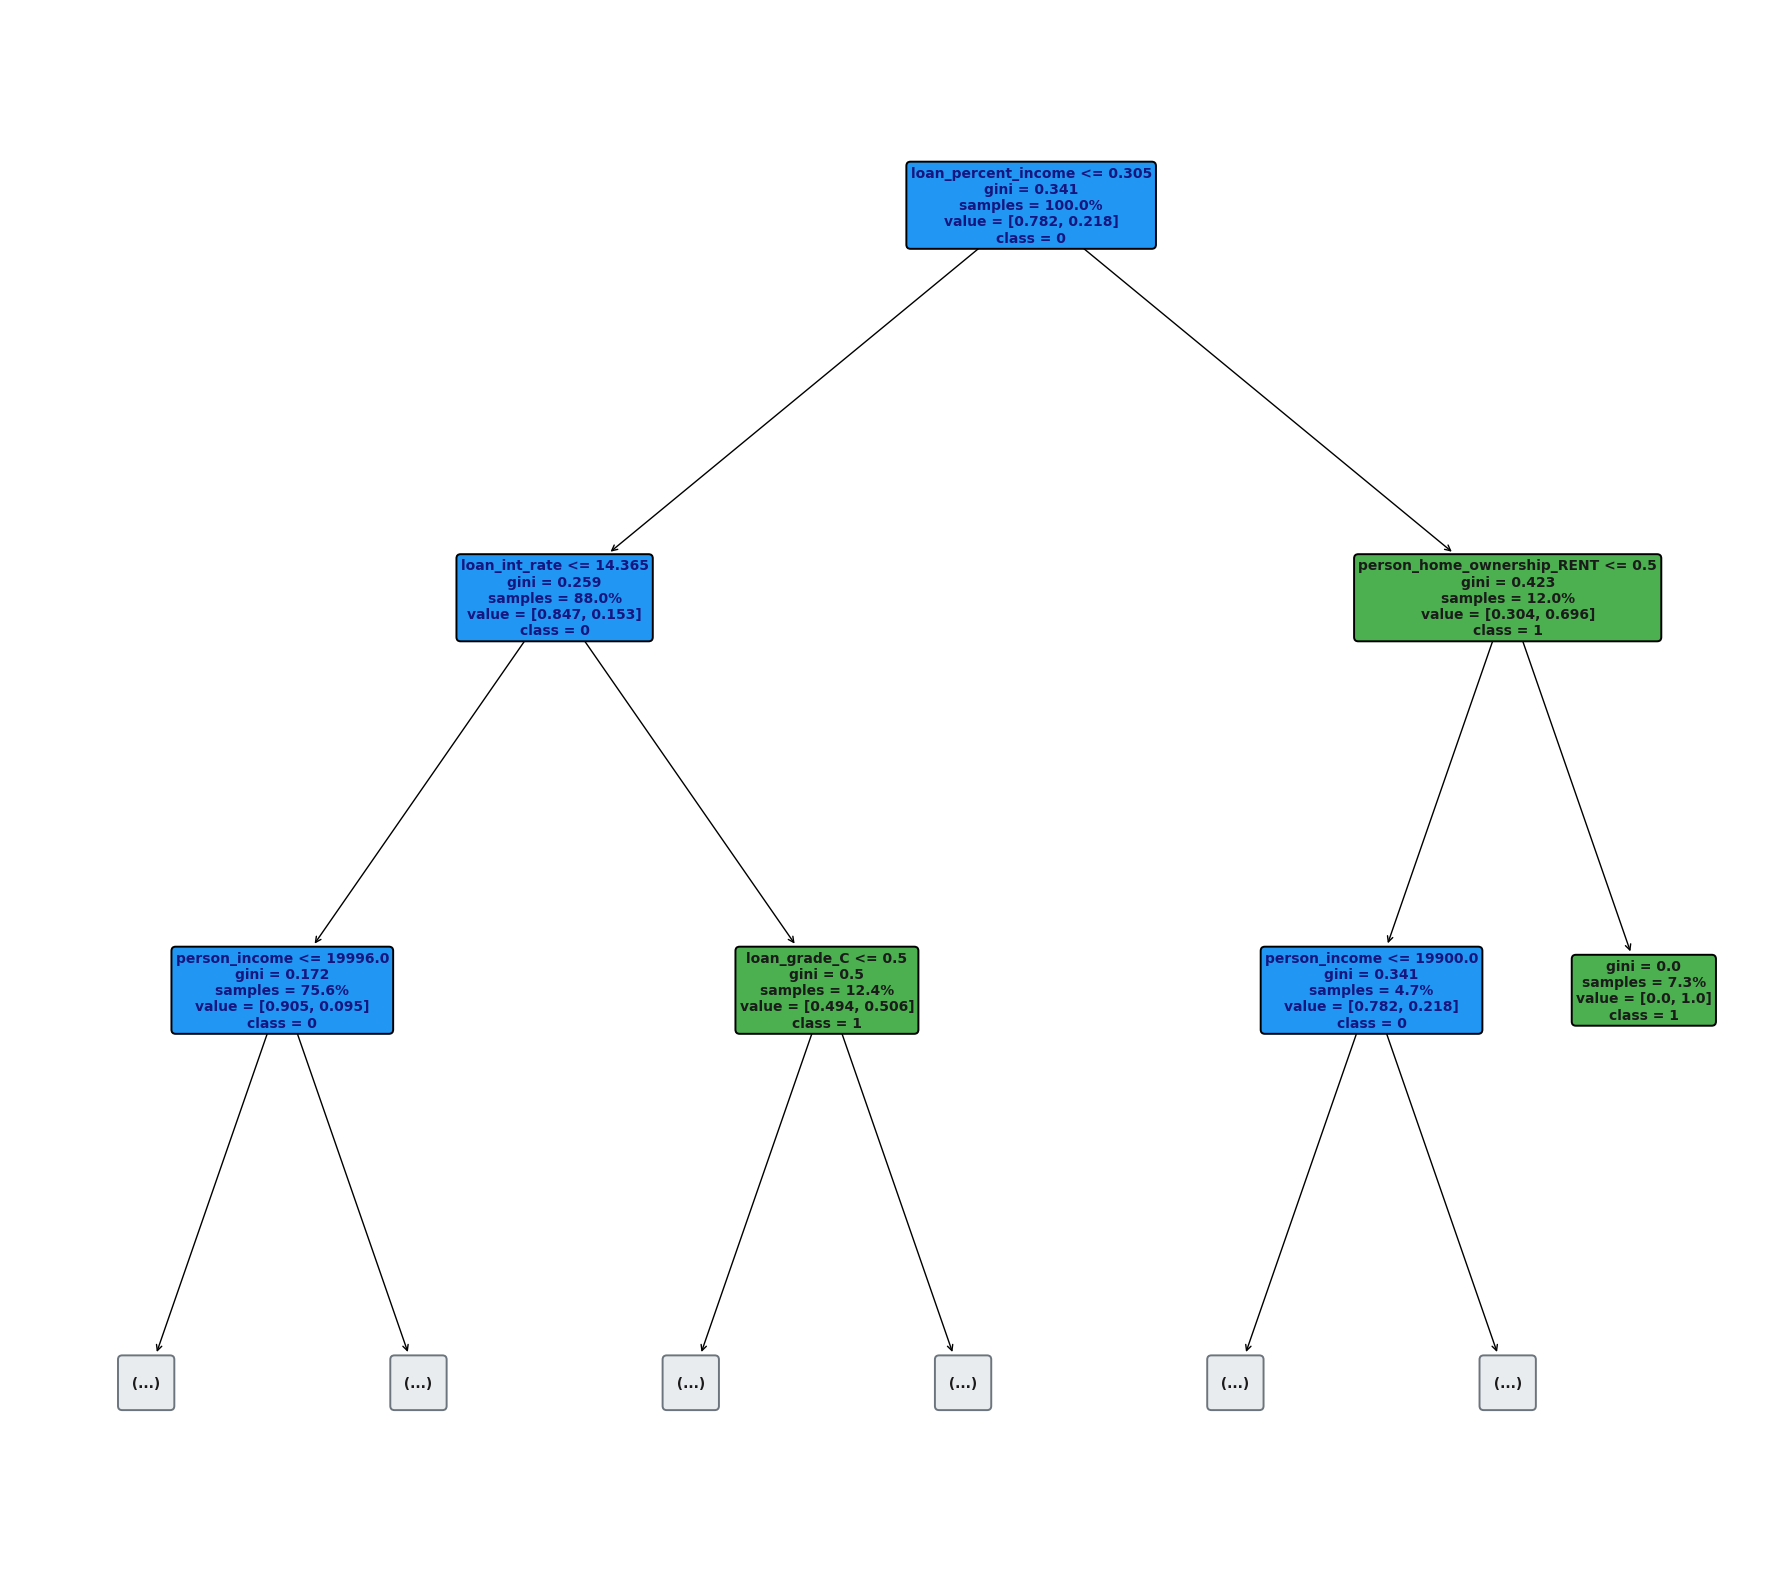

<Figure size 600x600 with 0 Axes>

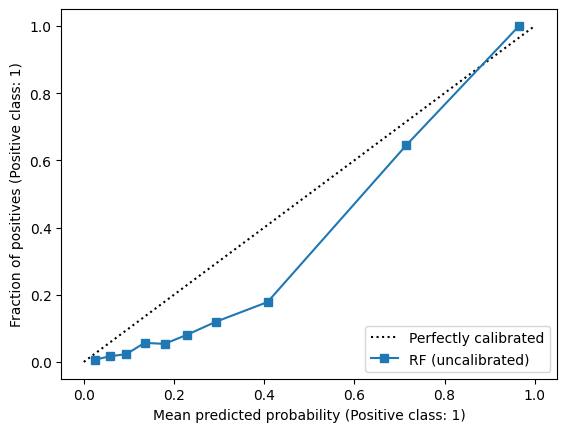

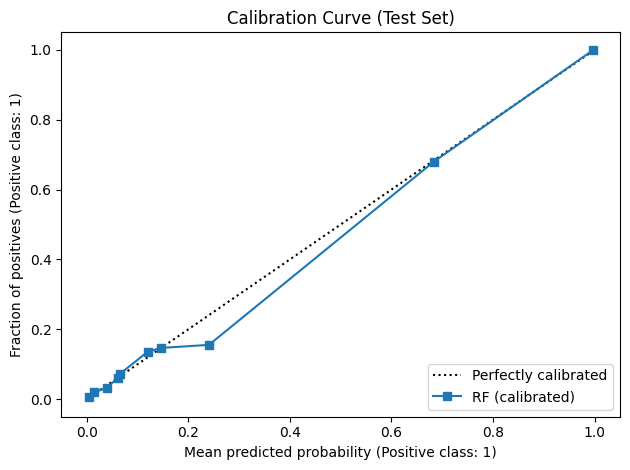

In [9]:
"""
Implementation of Tree-Based Classifiers
----------------------------------------

Binary classification on the Credit Risk dataset.

Models:
  - Decision Tree
  - Random Forest (OOB + isotonic calibration on a separate holdout)
  - XGBoost (early stopping on calib; robust fallback for old xgboost)

Metrics:
  - Accuracy, ROC-AUC, PR-AUC, F1, Log-Loss
  - Best-F1 threshold, OOB AUC for RF
  - Reliability plot (RF calibration)

Author: Dr. Leonard Pleschberger
Date  : August 19, 2025
"""

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.text import Text, Annotation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.isotonic import IsotonicRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    f1_score, log_loss, confusion_matrix
)

from scipy import sparse
import xgboost as xgb
from xgboost import XGBClassifier

# -------------------- Config --------------------
RANDOM_STATE = 42

# ---------------- I. Load & Split ----------------
df = pd.read_csv("credit_risk_dataset.csv")

X = df.drop(columns=["loan_status"])
# simple robust target: only value 1 -> 1, everything else -> 0
y = (pd.to_numeric(df["loan_status"], errors="coerce") == 1).astype(int)

# test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
# calibration/validation split out of train
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=RANDOM_STATE
)

# --------- II. Preprocessing (fit once, reuse) ----------
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = X.columns.difference(cat_cols).tolist()

# prefer sparse; handle sklearn <1.2 via fallback
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("encoder", ohe)])
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])

# keep output sparse; we densify only where required
pre = ColumnTransformer(
    [("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
    remainder="drop", sparse_threshold=1.0
)

pre.fit(X_train)
X_train_trafo = pre.transform(X_train)
X_cal_trafo   = pre.transform(X_cal)
X_test_trafo  = pre.transform(X_test)

to_dense = lambda A: A.toarray() if sparse.issparse(A) else A
Xtr_d, Xcal_d, Xte_d = map(to_dense, [X_train_trafo, X_cal_trafo, X_test_trafo])

# feature names for plotting
try:
    raw_names = pre.get_feature_names_out().tolist()
except Exception:
    raw_names = [f"f{i}" for i in range(X_train_trafo.shape[1])]
feature_names = [re.sub(r'^(num|cat)__', '', n) for n in raw_names]

# ----------------- III. Models (no pipelines) -------------------
# Decision Tree (dense)
decision_tree = DecisionTreeClassifier(max_depth=None, min_samples_leaf=20, random_state=RANDOM_STATE)
decision_tree.fit(Xtr_d, y_train)

# Random Forest (dense, OOB)
random_forest = RandomForestClassifier(
    n_estimators=500,
    max_features="sqrt",
    min_samples_leaf=10,
    class_weight="balanced_subsample",
    oob_score=True,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
random_forest.fit(Xtr_d, y_train)

# OOB AUC on training (from OOB decision function)
try:
    oob_proba = random_forest.oob_decision_function_[:, 1]
    oob_auc = roc_auc_score(y_train, oob_proba)
    print(f"OOB AUC (train): {oob_auc:.4f}")
except Exception:
    print("OOB AUC not available.")

# --------- IV. Isotonic Calibration on CALIB ----------
proba_rf_calib_raw = random_forest.predict_proba(Xcal_d)[:, 1]
iso_cal = IsotonicRegression(out_of_bounds="clip")
iso_cal.fit(proba_rf_calib_raw, y_cal)

# ------------- V. XGBoost with robust early stopping ---------------
pos = int(y_train.sum()); neg = int(len(y_train) - pos)
scale_pos_weight = neg / max(pos, 1)

def fit_xgb_with_es(Xtr, ytr, Xval, yval):
    # Try sklearn API first (newer xgboost)
    try:
        clf = XGBClassifier(
            objective="binary:logistic",
            eval_metric=["auc", "aucpr"],
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            scale_pos_weight=scale_pos_weight,
            n_estimators=2000,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            tree_method="hist"
        )
        clf.fit(
            Xtr, ytr,
            eval_set=[(Xval, yval)],
            early_stopping_rounds=100,
            verbose=False
        )
        return ("sklearn", clf)
    except TypeError:
        pass  # fall through to native booster
    # Native booster fallback (works with old wrappers)
    dtrain = xgb.DMatrix(Xtr, label=ytr)
    dval   = xgb.DMatrix(Xval, label=yval)
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["auc", "aucpr"],
        "eta": 0.05,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "lambda": 1.0,
        "scale_pos_weight": scale_pos_weight,
        "seed": RANDOM_STATE,
        "tree_method": "hist"
    }
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtrain, "train"), (dval, "calib")],
        early_stopping_rounds=100,
        verbose_eval=False
    )
    return ("booster", booster)

xgb_kind, xgb_model = fit_xgb_with_es(X_train_trafo, y_train, X_cal_trafo, y_cal)

# ----------------- VI. Evaluation -----------------
def evaluate(name, y_true, proba):
    eps = 1e-15
    proba = np.clip(proba, eps, 1 - eps)
    y_hat = (proba >= 0.5).astype(int)
    print(f"\n___ {name} ___")
    print(f"Accuracy : {accuracy_score(y_true, y_hat):.4f}")
    print(f"ROC-AUC  : {roc_auc_score(y_true, proba):.4f}")
    print(f"PR-AUC   : {average_precision_score(y_true, proba):.4f}")
    print(f"F1 @0.5  : {f1_score(y_true, y_hat):.4f}")
    print(f"Log-Loss : {log_loss(y_true, proba):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_hat))
    ths = np.linspace(0.01, 0.99, 99)
    f1s = [f1_score(y_true, (proba >= t).astype(int)) for t in ths]
    best_idx = int(np.argmax(f1s))
    print(f"Best F1  : {f1s[best_idx]:.4f} at thr={ths[best_idx]:.2f}")

# Decision Tree
proba_dt = decision_tree.predict_proba(Xte_d)[:, 1]
evaluate("Decision Tree", y_test, proba_dt)

# Random Forest (uncalibrated)
proba_rf = random_forest.predict_proba(Xte_d)[:, 1]
evaluate("Random Forest (uncalibrated)", y_test, proba_rf)
print(f"RF OOB score: {random_forest.oob_score_:.4f}")

# Random Forest (isotonic calibrated)
proba_rf_cal = iso_cal.predict(proba_rf)
evaluate("Random Forest (calibrated, isotonic)", y_test, proba_rf_cal)

# XGBoost
if xgb_kind == "sklearn":
    proba_xgb = xgb_model.predict_proba(X_test_trafo)[:, 1]
else:
    proba_xgb = xgb_model.predict(xgb.DMatrix(X_test_trafo))
evaluate("XGBoost (ES on calib, robust)", y_test, proba_xgb)

# ------------- VII. Visualization (tree) -------------
MAX_DEPTH = 2
fig, ax = plt.subplots(figsize=(18, 16))
artists = plot_tree(
    decision_tree, max_depth=MAX_DEPTH, filled=True, rounded=True, proportion=True,
    feature_names=feature_names, class_names=["0", "1"], fontsize=9, ax=ax
)

# remove True/False edge labels (cosmetic)
edge_texts = [a for a in artists if isinstance(a, (Text, Annotation)) and a.get_bbox_patch() is None]
for et in edge_texts:
    if et.get_text().strip() in {"True", "False"}:
        et.remove()

# optional recoloring by majority class
patches_ordered, texts_ordered, seen = [], [], set()
for a in artists:
    if isinstance(a, Text):
        patch = a.get_bbox_patch()
        if patch is None:
            continue
        pid = id(patch)
        if pid in seen:
            continue
        seen.add(pid)
        patches_ordered.append(patch)
        texts_ordered.append(a)

face0, edge0, txt0 = "#2196f3", "#000000", "#161680"
face1, edge1, txt1 = "#4caf50", "#000000", "#1A1C1A"
neutral_face, neutral_edge = "#e9ecef", "#6c757d"
val_re = re.compile(r"value\s*=\s*\[([0-9.,\s]+)\]")

for patch, txt in zip(patches_ordered, texts_ordered):
    node_text = txt.get_text() or ""
    m = val_re.search(node_text)
    if m:
        counts = [float(x) for x in m.group(1).replace(" ", "").split(",") if x]
        if len(counts) >= 2:
            majority = int(np.argmax(counts[:2]))
            if majority == 1:
                patch.set_facecolor(face1); patch.set_edgecolor(edge1); txt.set_color(txt1)
            else:
                patch.set_facecolor(face0); patch.set_edgecolor(edge0); txt.set_color(txt0)
        else:
            patch.set_facecolor(neutral_face); patch.set_edgecolor(neutral_edge); txt.set_color("0.1")
    else:
        patch.set_facecolor(neutral_face); patch.set_edgecolor(neutral_edge); txt.set_color("0.1")
    patch.set_linewidth(1.4); txt.set_fontsize(10); txt.set_fontweight("bold")

plt.tight_layout(); plt.show()

# ------- VIII. Reliability plot (calibration curve) -------
plt.figure(figsize=(8, 8))
CalibrationDisplay.from_predictions(
    y_test, proba_rf, n_bins=10, strategy="quantile", name="RF (uncalibrated)"
)
CalibrationDisplay.from_predictions(
    y_test, proba_rf_cal, n_bins=10, strategy="quantile", name="RF (calibrated)"
)
plt.title("Calibration Curve (Test Set)")
plt.tight_layout(); plt.show()